In [1]:
# general imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.nn.functional as F

In [2]:
# initialize device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
print(device)

NVIDIA A100-SXM4-80GB
cuda


In [3]:
# create model
from vision_lstm2 import VisionLSTM2
model = VisionLSTM2(
    dim=256,  # latent dimension (192 for ViL-T)
    depth=12,  # how many ViL blocks (1 block consists 2 subblocks of a forward and backward block)
    patch_size=8,  # patch_size (results in 64 patches for 32x32 images)
    input_shape=(4, 64, 64),  # RGB images with resolution 32x32
    output_shape=(2,),  # classifier with 10 classes
    drop_path_rate=0.0,  # stochastic depth parameter (disabled for ViL-T)
).to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")
print(model)

parameters: 10.2M
VisionLSTM2(
  (patch_embed): VitPatchEmbed(
    (proj): Conv2d(4, 256, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_embed): VitPosEmbed2d()
  (blocks): ModuleList(
    (0-11): 12 x ViLBlockPair(
      (rowwise_from_top_left): ViLBlock(
        (drop_path): DropPath(drop_prob=0.000)
        (norm): LayerNorm()
        (layer): ViLLayer(
          (proj_up): Linear(in_features=256, out_features=1024, bias=True)
          (q_proj): LinearHeadwiseExpand(dim=512, num_heads=128, bias=True, )
          (k_proj): LinearHeadwiseExpand(dim=512, num_heads=128, bias=True, )
          (v_proj): LinearHeadwiseExpand(dim=512, num_heads=128, bias=True, )
          (conv): SequenceConv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512)
          (mlstm_cell): MatrixLSTMCell(
            (igate): Linear(in_features=1536, out_features=4, bias=True)
            (fgate): Linear(in_features=1536, out_features=4, bias=True)
            (outnorm): MultiHeadLayerNorm

In [4]:
# wrap in torch.compile to speedup training
# we recommend to use torch.compile, but it results in the first update step taking a couple of minutes
# which might cause confusion -> we disable it by default
# model = torch.compile(model)

In [5]:
import pandas as pd
import os
import numpy as np
from rdkit import Chem
import torch
data = pd.read_csv("/raid/yyw/PharmDiGress/data/Acute_Toxicity_rat_oral_LD50.csv")
X_train = data['SMILES'].values.tolist()
y_train = data['rat_oral_LD50'].values.reshape(-1,1)
from torch.utils.data import Dataset
def smiles_to_graph(smiles, max_atoms=64):
    """
    从 SMILES 表示生成分子图的节点特征矩阵 (X) 和邻接矩阵 (A)。
    :param smiles: SMILES 字符串
    :param max_atoms: 固定最大原子数，用于统一矩阵大小
    :return: 节点特征矩阵 X 和邻接矩阵 A
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    
    # 获取原子数
    num_atoms = mol.GetNumAtoms()
    if num_atoms > max_atoms:
        raise ValueError(f"Number of atoms ({num_atoms}) exceeds max_atoms ({max_atoms})")
    
    # 初始化节点特征矩阵和邻接矩阵
    X = np.zeros((max_atoms, 3))  # 假设每个原子有 10 个特征
    A = np.zeros((max_atoms, max_atoms))
    
    # 构建节点特征矩阵 X
    for i, atom in enumerate(mol.GetAtoms()):
        X[i, 0] = atom.GetAtomicNum()  # 原子序数
        X[i, 1] = atom.GetDegree()  # 原子键的数目
        # X[i, 2] = atom.GetTotalNumHs()  # 氢原子数
        X[i, 2] = int(atom.GetIsAromatic())  # 是否芳香性
        # X[i, 4] = int(atom.GetChiralTag())  # 手性标签
        # 填充其他特征...
    
    # 构建邻接矩阵 A
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        # 如果需要区分键类型，可以使用权重表示:
        A[i, j] = bond.GetBondTypeAsDouble()
        A[j, i] = bond.GetBondTypeAsDouble()
    
    return X, A
def graph_to_image(X, A, max_nodes=64):
    """
    将分子图转换为图像格式。
    :param X: 节点特征矩阵 (n_nodes, n_features)
    :param A: 邻接矩阵 (n_nodes, n_nodes)
    :param max_nodes: 固定节点数，图像宽高 (max_nodes, max_nodes)
    :return: 图像张量 (C, H, W)
    """
    n_nodes, n_features = X.shape
    # 初始化图像张量
    img = np.zeros((n_features + 1, max_nodes, max_nodes))  # 通道数 = 节点特征数 + 邻接矩阵通道
    
    # 填充节点特征通道
    for i in range(n_features):
        img[i, :n_nodes, :n_nodes] = np.expand_dims(X[:, i], axis=1)  # 节点特征
        # feature_values = X[:, i]
        # if n_nodes > 0:
        #     img[i, :n_nodes, :n_nodes] = (feature_values - np.min(feature_values)) / (np.max(feature_values) - np.min(feature_values))

    # 填充邻接矩阵通道
    img[-1, :n_nodes, :n_nodes] = A
    
    return torch.tensor(img, dtype=torch.float32)
data_list, label_list=[], []
for i, smi in enumerate(X_train):
    try:
        X, A = smiles_to_graph(smi)
    except:
        continue
    img_tensor = graph_to_image(X, A)
    data_list.append(img_tensor)
    if y_train[i] * 0.1 >= 0.05:
        label_list.append([1])
    else:
        label_list.append([0])

In [6]:
# hyperparameters
batch_size = 128
epochs = 10
lr = 1e-3
weight_decay = 0.01

In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data_list, label_list, train_size=0.75, random_state=42)
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        """
        初始化数据集
        :param features: list or np.array, 输入特征
        :param labels: list or np.array, 对应的标签
        """
        self.features = torch.stack(features)
        self.labels = torch.tensor(labels)

    def __len__(self):
        """返回数据集大小"""
        return len(self.features)

    def __getitem__(self, idx):
        """
        根据索引返回数据
        :param idx: int, 索引
        :return: tuple, (feature, label)
        """
        return self.features[idx], self.labels[idx]
train_dataset = CustomDataset(train_X, train_y)
test_dataset = CustomDataset(test_X, test_y)
from torch.utils.data import DataLoader

# 定义数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# setup dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# initialize optimizer and learning rate schedule (linear warmup for first 10% -> linear decay)
optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_updates = len(train_loader) * epochs
warmup_updates = int(total_updates * 0.1)
# lrs = torch.concat(
#     [
#         # linear warmup
#         torch.linspace(0, optim.defaults["lr"], warmup_updates),
#         # linear decay
#         torch.linspace(optim.defaults["lr"], 0, total_updates - warmup_updates),
#     ],
# )

# train model
update = 0
pbar = tqdm(total=total_updates)
pbar.update(0)
pbar.set_description("train_loss: ????? train_rmse: ????% test_rmse: ????%")
test_accuracy = 0.0
train_losses = []
train_accuracies = []
test_accuracies = []
loss = None
train_accuracy = None
for i in range(epochs):
    # train for an epoch
    model.train()
    for x, y in train_loader:
        # prepare forward pass
        x = x.to(device)
        y = y.to(device)

        # schedule learning rate
        # for param_group in optim.param_groups:
        #     param_group["lr"] = float(lrs[update])

        # forward pass (this tutorial doesnt use mixed precision because T4 cards dont support bfloat16)
        # we recommend bfloat16 mixed precision training
        y_hat = model(x)
        
        # loss = F.mse_loss(y_hat, y)
        loss = F.cross_entropy(y_hat, y.squeeze(1))

        # backward pass
        loss.backward()

        # update step
        optim.step()
        optim.zero_grad()

        # status update
        # train_accuracy = ((y_hat.argmax(dim=1) == y).sum() / y.numel()).item()
        train_accuracy = ((torch.sigmoid(y_hat)[:, 1] > 0.05).long() == y).sum().item() / y.numel()
        # train_rmse = torch.sqrt(loss)
        update += 1
        pbar.update()
        pbar.set_description(
            f"epoch: {i:.4f}"
            f"train_loss: {loss.item():.4f} "
            f"train_accuracy: {train_accuracy:4.1f}"
            f"test_accuracy: {test_accuracy:4.1f}"
        )
        train_losses.append(loss.item())
        train_accuracies.append(train_accuracy)

    update = 0

    # evaluate
    num_correct = 0
    model.eval()
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_hat = model(x)
            # num_correct += (y_hat.argmax(dim=1) == y).sum().item()
            num_correct += ((torch.sigmoid(y_hat)[:, 1] > 0.05).long() == y).sum().item() / y.numel()
            # test_rmse = torch.sqrt(F.mse_loss(y_hat, y))
    test_accuracy = num_correct / len(test_dataset)
    test_accuracies.append(test_accuracy)
    pbar.set_description(
        f"epoch: {i:.4f}"
        f"train_loss: {loss.item():.4f} "
        f"train_accuracy: {train_accuracy:4.1f}"
        f"test_accuracy: {test_accuracy:4.1f}"
    )
pbar.close()

  0%|          | 0/580 [00:00<?, ?it/s]

In [9]:
y_true, y_pred, y_scores = [],[],[]
for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_hat = model(x)
    y_true.append(y.squeeze(1).cpu())
    y_pred.append((torch.sigmoid(y_hat)[:, 1] > 0.05).long().cpu())
    y_scores.append(torch.sigmoid(y_hat)[:,1].cpu())
y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()
y_scores = torch.cat(y_scores).numpy()
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix,
    log_loss,
    matthews_corrcoef
)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
logloss = log_loss(y_true, y_scores)
mcc = matthews_corrcoef(y_true, y_pred)

# 计算 ROC 曲线和 AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Log Loss: {logloss:.4f}')
print(f'Matthews Correlation Coefficient: {mcc:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

Accuracy: 0.9992
Precision: 0.9992
Recall: 1.0000
F1 Score: 0.9996
Confusion Matrix:
[[   0    2]
 [   0 2450]]
Log Loss: 0.0122
Matthews Correlation Coefficient: 0.0000
ROC AUC: 0.7522


In [17]:
y

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')

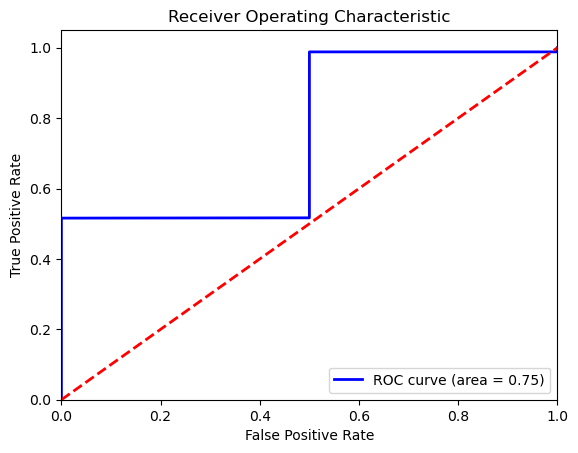

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# 选择最佳阈值（例如，最接近 (0,1) 的点）
optimal_idx = np.argmax(tpr - fpr)
best_threshold_roc = thresholds[optimal_idx]

In [11]:
best_threshold_roc

0.99177283

# Potential Issues
- `optim.step()` throws an error ([issue](https://github.com/NX-AI/vision-lstm/issues/16))
    - update your pytorch version
    - use SGD
    - remove lr scheduling (`for param_group in optim.param_groups: param_group["lr"] = lrs[update]`)